__author__      = "Yibo HU"

Last_updated: 12/21/2020

This is a jupyter notebook of the annotation pipeline
modified from 

https://github.com/the-knightfury/SATP-Event-Classification-V1/tree/master/SourceCode

Thanks to Shahreen


For new updates in annotations, simply import the libraries below and run step 5 only.

In [1]:
# -*- coding: utf-8 -*-
import requests
from bs4 import BeautifulSoup
import re
import sklearn
import time
import numpy as np
import json

import pandas as pd
pd.set_option('max_colwidth', 200)

# 1. crawler_terrorism_articles_tags

In [2]:
countries = ["bangladesh", "india", "pakistan", "bhutan", "nepal", "maldives", "afghanistan", "srilanka"]
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
years = list(np.arange(2000,2020+1))
print('year', years)

year [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [3]:
import itertools
items = itertools.product(*[countries, months, years])
items = list(items)
df = pd.DataFrame(items, columns=['country', 'month', 'year'])

base_url = "https://www.satp.org/terrorist-activity/"
df['url'] = base_url + df['country'] + "-" + df['month'] + "-" + df['year'].apply(str)
df

,country,month,year,url
0,bangladesh,jan,2000,https://www.satp.org/terrorist-activity/bangladesh-jan-2000
1,bangladesh,jan,2001,https://www.satp.org/terrorist-activity/bangladesh-jan-2001
2,bangladesh,jan,2002,https://www.satp.org/terrorist-activity/bangladesh-jan-2002
3,bangladesh,jan,2003,https://www.satp.org/terrorist-activity/bangladesh-jan-2003
4,bangladesh,jan,2004,https://www.satp.org/terrorist-activity/bangladesh-jan-2004
...,...,...,...,...
2011,srilanka,dec,2016,https://www.satp.org/terrorist-activity/srilanka-dec-2016
2012,srilanka,dec,2017,https://www.satp.org/terrorist-activity/srilanka-dec-2017
2013,srilanka,dec,2018,https://www.satp.org/terrorist-activity/srilanka-dec-2018
2014,srilanka,dec,2019,https://www.satp.org/terrorist-activity/srilanka-dec-2019


In [4]:
%%time
from pandarallel import pandarallel
pandarallel.initialize()

def get_items_per_url(url):
    r1 = requests.get(url)
    coverpage = r1.content
    soup = BeautifulSoup(coverpage, 'html.parser')
    
    coverpage_news = soup.find_all('div', class_='more')
    coverpage_date = soup.find_all('td',style="width: 15%;")
  
    news_size = len(coverpage_news)
    #print(news_size)
           
    news_contents, news_dates = [], []
    for date, paragraph in zip(coverpage_date, coverpage_news):
        paragraph = paragraph.get_text()
        paragraph = re.sub("^\s+|\s+$", "", paragraph, flags=re.UNICODE)
        paragraph = " ".join(re.split("\s+", paragraph, flags=re.UNICODE)[:-2])
        news_contents.append(paragraph)
        
        date = date.get_text()
        date = re.sub("^\s+|\s+$", "", date, flags=re.UNICODE)
        # date = paragraph.split()[2]
        news_dates.append(date)
        
    return pd.Series([news_size, news_dates, news_contents])

df[['news_size','date','news_contents']] = df['url'].parallel_apply(get_items_per_url)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 252 ms, sys: 300 ms, total: 552 ms
Wall time: 10min 25s


There are urls that doesn't have records. Remove them

In [5]:
df[df.news_size == 0]

,country,month,year,url,news_size,date,news_contents
0,bangladesh,jan,2000,https://www.satp.org/terrorist-activity/bangladesh-jan-2000,0,[],[]
21,bangladesh,feb,2000,https://www.satp.org/terrorist-activity/bangladesh-feb-2000,0,[],[]
252,india,jan,2000,https://www.satp.org/terrorist-activity/india-jan-2000,0,[],[]
504,pakistan,jan,2000,https://www.satp.org/terrorist-activity/pakistan-jan-2000,0,[],[]
525,pakistan,feb,2000,https://www.satp.org/terrorist-activity/pakistan-feb-2000,0,[],[]
...,...,...,...,...,...,...,...
1756,afghanistan,dec,2013,https://www.satp.org/terrorist-activity/afghanistan-dec-2013,0,[],[]
1759,afghanistan,dec,2016,https://www.satp.org/terrorist-activity/afghanistan-dec-2016,0,[],[]
1760,afghanistan,dec,2017,https://www.satp.org/terrorist-activity/afghanistan-dec-2017,0,[],[]
1764,srilanka,jan,2000,https://www.satp.org/terrorist-activity/srilanka-jan-2000,0,[],[]


 Remove the pages that doesn't have records

In [7]:
df = df[df.news_size != 0]
df

,country,month,year,url,news_size,date,news_contents
1,bangladesh,jan,2001,https://www.satp.org/terrorist-activity/bangladesh-jan-2001,22,"[January - 1, January - 1, January - 4, January - 5, January - 6, January - 6, January - 6, January - 6, January - 15, January - 19, January - 20, January - 21, January - 23, January - 23, January...","[Meanwhile, on the same day, people across the country held peace rallies under the banner of 'Anti-terrorism Peace Movement' with a call to build a terrorism-free society in Bangladesh., Police i..."
2,bangladesh,jan,2002,https://www.satp.org/terrorist-activity/bangladesh-jan-2002,9,"[January - 3, January - 5, January - 5, January - 6, January - 6, January - 6, January - 28, January - 30, January - 31]","[According to media reports, the opposition Awami League (AL) alleged during a meeting with visiting British Prime Minister Tony Blair, that two Cabinet Ministers have links with the Taliban. A fo..."
3,bangladesh,jan,2003,https://www.satp.org/terrorist-activity/bangladesh-jan-2003,49,"[January - 1, January - 3, January - 3, January - 3, January - 3, January - 5, January - 5, January - 6, January - 6, January - 7, January - 7, January - 7, January - 7, January - 8, January - 8, ...","[Joint teams of security forces arrested 62 people, including 14 listed terrorists/criminals, across the country on January 1, 2003, in the ongoing drive against criminals and terrorists launched ..."
4,bangladesh,jan,2004,https://www.satp.org/terrorist-activity/bangladesh-jan-2004,81,"[January - 1, January - 1, January - 2, January - 2, January - 2, January - 3, January - 3, January - 3, January - 3, January - 3, January - 4, January - 4, January - 5, January - 5, January - 5, ...","[According to The Daily Star, the Bangladesh Rifles (BDR) personnel arrested six terrorists and seized illegal arms and ammunition from their possession at Chunarughat in the Sylhet district on Ja..."
5,bangladesh,jan,2005,https://www.satp.org/terrorist-activity/bangladesh-jan-2005,48,"[January - 1, January - 1, January - 2, January - 2, January - 3, January - 3, January - 6, January - 6, January - 10, January - 10, January - 10, January - 12, January - 12, January - 12, January...","[Daily Star reports that Nyamat Ali alias Nyiat, a cadre of the Purbo Banglar Communist Party (PBCP-Janajuddha), was killed in 'crossfire' with police in Alamdanga subdistrict in Chuadanga distric..."
...,...,...,...,...,...,...,...
2011,srilanka,dec,2016,https://www.satp.org/terrorist-activity/srilanka-dec-2016,29,"[December - 3, December - 5, December - 7, December - 8, December - 11, December - 11, December - 12, December - 12, December - 14, December - 15, December - 16, December - 17, December - 19, Dece...","[Secretary to the Ministry of Defense, Eng. Karunasena Hettiarachchion December 3 asserted that there is no truth to the rumors spread by the extremists that security in North and East are in dang..."
2012,srilanka,dec,2017,https://www.satp.org/terrorist-activity/srilanka-dec-2017,11,"[December - 4, December - 5, December - 7, December - 12, December - 13, December - 15, December - 18, December - 18, December - 19, December - 21, December - 28]","[The Court of Appeal has dismissed a Writ Petition filed by the Marxist party, Janatha Vimukthi Peramuna (JVP) seeking an order to arrest and prosecute former Liberation Tigers of Tamil Eelam (LTT..."
2013,srilanka,dec,2018,https://www.satp.org/terrorist-activity/srilanka-dec-2018,26,"[December - 1, December - 2, December - 3, December - 4, December - 5, December - 6, December - 7, December - 8, December - 9, December - 11, December - 11, December - 12, December - 13, December ...","[Liberation Tigers of Tamil Eelam (LTTE) in an alleged statement on December 1 denied that they had any link to the assassination of India's former Prime Minister Rajiv Gandhi in May 1991, reports..."
2014,srilanka,dec,2019,https://www.satp.org/terrorist-activity/srilanka-dec-2019,12,"[December - 2, December - 3, December 

In [14]:
df.to_csv ('RawSATPData/raw_2000_to_2020_url.csv', index = False, header=True)

,country,month,year,url,news_size,date,news_contents
0,bangladesh,jan,2001,https://www.satp.org/terrorist-activity/bangladesh-jan-2001,22,"['January - 1', 'January - 1', 'January - 4', 'January - 5', 'January - 6', 'January - 6', 'January - 6', 'January - 6', 'January - 15', 'January - 19', 'January - 20', 'January - 21', 'January - ...","[""Meanwhile, on the same day, people across the country held peace rallies under the banner of 'Anti-terrorism Peace Movement' with a call to build a terrorism-free society in Bangladesh."", 'Polic..."
1,bangladesh,jan,2002,https://www.satp.org/terrorist-activity/bangladesh-jan-2002,9,"['January - 3', 'January - 5', 'January - 5', 'January - 6', 'January - 6', 'January - 6', 'January - 28', 'January - 30', 'January - 31']","['According to media reports, the opposition Awami League (AL) alleged during a meeting with visiting British Prime Minister Tony Blair, that two Cabinet Ministers have links with the Taliban. A f..."
2,bangladesh,jan,2003,https://www.satp.org/terrorist-activity/bangladesh-jan-2003,49,"['January - 1', 'January - 3', 'January - 3', 'January - 3', 'January - 3', 'January - 5', 'January - 5', 'January - 6', 'January - 6', 'January - 7', 'January - 7', 'January - 7', 'January - 7', ...","['Joint teams of security forces arrested 62 people, including 14 listed terrorists/criminals, across the country on January 1, 2003, in the ongoing drive against criminals and terrorists launched..."
3,bangladesh,jan,2004,https://www.satp.org/terrorist-activity/bangladesh-jan-2004,81,"['January - 1', 'January - 1', 'January - 2', 'January - 2', 'January - 2', 'January - 3', 'January - 3', 'January - 3', 'January - 3', 'January - 3', 'January - 4', 'January - 4', 'January - 5', ...","['According to The Daily Star, the Bangladesh Rifles (BDR) personnel arrested six terrorists and seized illegal arms and ammunition from their possession at Chunarughat in the Sylhet district on J..."
4,bangladesh,jan,2005,https://www.satp.org/terrorist-activity/bangladesh-jan-2005,48,"['January - 1', 'January - 1', 'January - 2', 'January - 2', 'January - 3', 'January - 3', 'January - 6', 'January - 6', 'January - 10', 'January - 10', 'January - 10', 'January - 12', 'January - ...","[""Daily Star reports that Nyamat Ali alias Nyiat, a cadre of the Purbo Banglar Communist Party (PBCP-Janajuddha), was killed in 'crossfire' with police in Alamdanga subdistrict in Chuadanga distri..."
...,...,...,...,...,...,...,...
1429,srilanka,dec,2016,https://www.satp.org/terrorist-activity/srilanka-dec-2016,29,"['December - 3', 'December - 5', 'December - 7', 'December - 8', 'December - 11', 'December - 11', 'December - 12', 'December - 12', 'December - 14', 'December - 15', 'December - 16', 'December - ...","['Secretary to the Ministry of Defense, Eng. Karunasena Hettiarachchion December 3 asserted that there is no truth to the rumors spread by the extremists that security in North and East are in dan..."
1430,srilanka,dec,2017,https://www.satp.org/terrorist-activity/srilanka-dec-2017,11,"['December - 4', 'December - 5', 'December - 7', 'December - 12', 'December - 13', 'December - 15', 'December - 18', 'December - 18', 'December - 19', 'December - 21', 'December - 28']","['The Court of Appeal has dismissed a Writ Petition filed by the Marxist party, Janatha Vimukthi Peramuna (JVP) seeking an order to arrest and prosecute former Liberation Tigers of Tamil Eelam (LT..."
1431,srilanka,dec,2018,https://www.satp.org/terrorist-activity/srilanka-dec-2018,26,"['December - 1', 'December - 2', 'December - 3', 'December - 4', 'December - 5', 'December - 6', 'December - 7', 'December - 8', 'December - 9', 'December - 11', 'December - 11', 'December - 12', ...","['Liberation Tigers of Tamil Eelam (LTTE) in an alleged statement on December 1 denied that they had any link to the assassination of India\'s former Prime Minister Rajiv Gandhi in May 1991, repor..."
1432,srilanka,dec,2019,https://www.satp.org/terrorist-activity/srilanka-dec-2019

# 2. Expand the list in the news_contents to multiple rows

In [41]:
df = pd.read_csv('RawSATPData/raw_2000_to_2020_url.csv', header=[0],
                 converters={'date': eval,'news_contents': eval})
df

,country,month,year,url,news_size,date,news_contents
0,bangladesh,jan,2001,https://www.satp.org/terrorist-activity/bangladesh-jan-2001,22,"[January - 1, January - 1, January - 4, January - 5, January - 6, January - 6, January - 6, January - 6, January - 15, January - 19, January - 20, January - 21, January - 23, January - 23, January...","[Meanwhile, on the same day, people across the country held peace rallies under the banner of 'Anti-terrorism Peace Movement' with a call to build a terrorism-free society in Bangladesh., Police i..."
1,bangladesh,jan,2002,https://www.satp.org/terrorist-activity/bangladesh-jan-2002,9,"[January - 3, January - 5, January - 5, January - 6, January - 6, January - 6, January - 28, January - 30, January - 31]","[According to media reports, the opposition Awami League (AL) alleged during a meeting with visiting British Prime Minister Tony Blair, that two Cabinet Ministers have links with the Taliban. A fo..."
2,bangladesh,jan,2003,https://www.satp.org/terrorist-activity/bangladesh-jan-2003,49,"[January - 1, January - 3, January - 3, January - 3, January - 3, January - 5, January - 5, January - 6, January - 6, January - 7, January - 7, January - 7, January - 7, January - 8, January - 8, ...","[Joint teams of security forces arrested 62 people, including 14 listed terrorists/criminals, across the country on January 1, 2003, in the ongoing drive against criminals and terrorists launched ..."
3,bangladesh,jan,2004,https://www.satp.org/terrorist-activity/bangladesh-jan-2004,81,"[January - 1, January - 1, January - 2, January - 2, January - 2, January - 3, January - 3, January - 3, January - 3, January - 3, January - 4, January - 4, January - 5, January - 5, January - 5, ...","[According to The Daily Star, the Bangladesh Rifles (BDR) personnel arrested six terrorists and seized illegal arms and ammunition from their possession at Chunarughat in the Sylhet district on Ja..."
4,bangladesh,jan,2005,https://www.satp.org/terrorist-activity/bangladesh-jan-2005,48,"[January - 1, January - 1, January - 2, January - 2, January - 3, January - 3, January - 6, January - 6, January - 10, January - 10, January - 10, January - 12, January - 12, January - 12, January...","[Daily Star reports that Nyamat Ali alias Nyiat, a cadre of the Purbo Banglar Communist Party (PBCP-Janajuddha), was killed in 'crossfire' with police in Alamdanga subdistrict in Chuadanga distric..."
...,...,...,...,...,...,...,...
1429,srilanka,dec,2016,https://www.satp.org/terrorist-activity/srilanka-dec-2016,29,"[December - 3, December - 5, December - 7, December - 8, December - 11, December - 11, December - 12, December - 12, December - 14, December - 15, December - 16, December - 17, December - 19, Dece...","[Secretary to the Ministry of Defense, Eng. Karunasena Hettiarachchion December 3 asserted that there is no truth to the rumors spread by the extremists that security in North and East are in dang..."
1430,srilanka,dec,2017,https://www.satp.org/terrorist-activity/srilanka-dec-2017,11,"[December - 4, December - 5, December - 7, December - 12, December - 13, December - 15, December - 18, December - 18, December - 19, December - 21, December - 28]","[The Court of Appeal has dismissed a Writ Petition filed by the Marxist party, Janatha Vimukthi Peramuna (JVP) seeking an order to arrest and prosecute former Liberation Tigers of Tamil Eelam (LTT..."
1431,srilanka,dec,2018,https://www.satp.org/terrorist-activity/srilanka-dec-2018,26,"[December - 1, December - 2, December - 3, December - 4, December - 5, December - 6, December - 7, December - 8, December - 9, December - 11, December - 11, December - 12, December - 13, December ...","[Liberation Tigers of Tamil Eelam (LTTE) in an alleged statement on December 1 denied that they had any link to the assassination of India's former Prime Minister Rajiv Gandhi in May 1991, reports..."
1432,srilanka,dec,2019,https://www.satp.org/terrorist-activity/srilanka-dec-2019,12,"[December - 2, December - 3, December 

<AxesSubplot:>

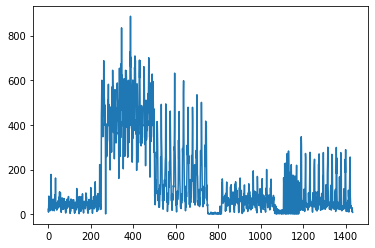

In [48]:
df.news_size.plot()

In [61]:
df = df.apply(lambda x: x.explode() if x.name in ['date',	'news_contents'] else x).reset_index(drop= True)
df = df[['country','month','year','date', 'news_contents']]
df

,country,month,year,date,news_contents
0,bangladesh,jan,2001,January - 1,"Meanwhile, on the same day, people across the country held peace rallies under the banner of 'Anti-terrorism Peace Movement' with a call to build a terrorism-free society in Bangladesh."
1,bangladesh,jan,2001,January - 1,"Police in Dhaka, on January 1, recovered some arms and ammunition from the Dhaka University campus and also arrested one person in this connection."
2,bangladesh,jan,2001,January - 4,One person was killed and two others injured by a group of terrorists at Char Chandia village in Sonagazi on January 4.
3,bangladesh,jan,2001,January - 5,"At least 15 people were injured in an attack by a gang of terrorists in village Sharnakarpura, on January 5. Police and local people said the attack was a sequel to the January 1-incident at the v..."
4,bangladesh,jan,2001,January - 6,"In a separate incident, two terrorists, involved in an earlier killing of a civilian in Narayanganj district were arrested in the city."
...,...,...,...,...,...
206848,srilanka,dec,2020,December - 11,Prime Minister Mahinda Rajapaksa on December 11 instructed the Election Commission (EC) to pay attention to holding of the Provincial Council Elections expeditiously and look into the necessary le...
206849,srilanka,dec,2020,December - 14,Former Minister of Muslim Affairs M.H.A. Haleem testifying before the Presidential Commission of Inquiry (PCoI) probing Easter Sunday on December 14 said he was unaware National Thowheed Jamaat (N...
206850,srilanka,dec,2020,December - 18,"Three major political parties in the North have begun discussions to present a resolution on behalf of their constituents at the 46th UN Human Rights Council (UNHRC) meeting in Geneva next March, ..."
206851,srilanka,dec,2020,December - 24,Russian Ambassador Yury B. Materiy on December 24 apprised Public Security Minister Sarath Weerasekara about terrorist financing activities by extremist groups under the pretext of providing COVID...


In [57]:
(df.news_contents.str.count(' ')+1).sum()

16898027

In [55]:
df.news_contents.str.count(' ')+1

0          29
1          24
2          22
3          47
4          22
         ... 
206848     55
206849     82
206850     92
206851    137
206852    106
Name: news_contents, Length: 206853, dtype: int64

In [10]:
(df.set_index(list(df.columns[0:5]))
              .apply(lambda x: x.apply(pd.Series).stack())
              .reset_index()
              .drop('level_1', 1))

KeyError: "['level_1'] not found in axis"

# 3. process_data_for_annotation

In [2]:
def remove_special_characters(data, col_name):
    spec_chars = ["!", '"', "#", "%", "&", "'", "*", "+", "-", "/", ":", ";", "<", "=",
                  ">", "?", "@", "[", "\\", "]", "^", "_", "`", "{", "|", "}", "~", "–"]
    for char in spec_chars:
        data[col_name] = data[col_name].str.replace(char, ' ')
    data[col_name] = data[col_name].str.split().str.join(" ")
    return data

def probable_relevant_story(news, event_set, threshold):
    tokenized = news.split(" ")
    count = 0
    for t in tokenized:
        if t in event_set:
            count += 1
        if count >= threshold:
            return True
    return False

In [3]:
master_data_path = 'RawSATPData/master_2011To2015.csv'
master_data = pd.read_csv(master_data_path, header=[0])  
master_data = remove_special_characters(master_data, 'news')

In [4]:
action_path = "Data_Events/action.csv" 
actions = pd.read_csv(action_path, header=None)   #  Here header should be None instead of [0] in the previous version
actions_set = set(actions.iloc[:,0])
len(actions_set)

193

## Assume a threshold = 4 to select samples 

In [9]:
# Step - 1 : Pull Out All the Probable relevant story
master_data['Relevance'] = master_data['news'].apply(probable_relevant_story, args = (actions_set, 4))
print(master_data[master_data['Relevance'] == True].shape)

(21902, 5)


## save master data

In [5]:
master_data

,year,month,location,news
0,2015,1,bangladesh,"On January 1, in Jhenidah, Police arrested nin..."
1,2015,1,bangladesh,"Police recovered a 7.6mm foreign pistol, a pip..."
2,2015,1,bangladesh,The prosecution on January 1 filed a petition ...
3,2015,1,bangladesh,Police banned all protests in Dhaka city from ...
4,2015,1,bangladesh,Road Transport and Bridges Minister Obaidul Qu...
...,...,...,...,...
65078,2011,12,srilanka,President Mahinda Rajapakse said that the Army...
65079,2011,12,srilanka,Cabinet spokesman and Mass Media and Informati...
65080,2011,12,srilanka,Cabinet spokesman and Mass Media and Informati...
65081,2011,12,srilanka,An ally of Sri Lanka s governing United People...


In [ ]:
master_data.to_csv('Data_TagTog_NotAnnotated/master_2011to2015_probable_relevant_marked_data.csv', header=True, index=True, index_label='index')


# 4. sample_data_for_annotation

In [ ]:
# master_data = pd.read_csv('Data_TagTog_NotAnnotated/master_2011to2015_probable_relevant_marked_data.csv', header=[0])

<AxesSubplot:>

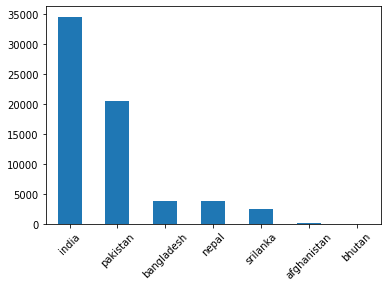

In [6]:
master_data['location'].value_counts().plot.bar(rot=45)

<AxesSubplot:>

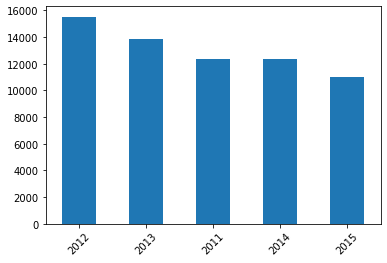

In [7]:
master_data['year'].value_counts().plot.bar(rot=45)

## Sample 3000 rows each year

In [10]:
relevant = master_data[master_data["Relevance"] == True]
grouped_df = relevant.groupby('year')
# for key, item in grouped_df:
#     print(grouped_df.get_group(key), "\n\n")

In [11]:
sample_df = relevant.groupby('year').apply(lambda x: x.sample(3000))
sample_df

year  month  location  \
year                                
2011 61704  2011      7  pakistan   
     57597  2011      9     india   
     57025  2011      8     india   
     54760  2011      4     india   
     53994  2011      2     india   
...          ...    ...       ...   
2015 3625   2015      6     india   
     8755   2015      8  pakistan   
     6061   2015     10     india   
     2769   2015      4     india   
     8152   2015      5  pakistan   

                                                         news  Relevance  
year                                                                      
2011 61704  The Inter Services Intelligence (ISI) official...       True  
     57597  Calling Naxalism (Left Wing Extremism) a bigge...       True  
     57025  The Indian Navy captured a hijacked Iranian fl...       True  
     54760  Times of India reports that Chichgarh squad of...       True  
     53994  Indian Express reports that the cadres of the ...       True  
...                                                       ...        ...  
2015 3625   Death toll rises to three as one more militant...       True  
     8755   Lahore High Court (LHC) issued a notice to the...       True  
     6061   As there was early snowfall along the Line of ...       True  
     2769   Chinar Corps General Officer Commanding (GOC) ...       True  
     8152   The United States (US) has handed over 14 comb...       True  

[15000 rows x 5 columns]

<AxesSubplot:>

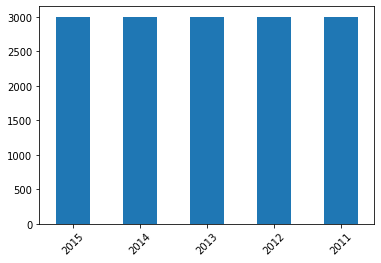

In [12]:
sample_df['year'].value_counts().plot.bar(rot=45)

<AxesSubplot:>

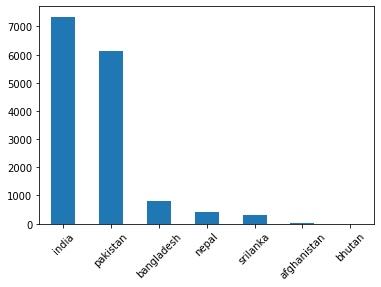

In [13]:
sample_df['location'].value_counts().plot.bar(rot=45)

In [14]:
print('Relevance:\n')
print(sample_df['Relevance'].value_counts())

Relevance:

True    15000
Name: Relevance, dtype: int64


## Sample 60% from each location (Total 9000)

In [15]:
sample_df = sample_df.groupby('location').apply(lambda x: x.sample(frac = 0.6))
sample_df

year  month     location  \
location    year                                   
afghanistan 2015 10529  2015      7  afghanistan   
                 10523  2015      3  afghanistan   
                 10527  2015      7  afghanistan   
                 10525  2015      3  afghanistan   
            2011 64582  2011      9  afghanistan   
...                      ...    ...          ...   
srilanka    2012 52294  2012      1     srilanka   
            2013 36942  2013      6     srilanka   
            2014 23277  2014     11     srilanka   
            2013 36829  2013      4     srilanka   
            2014 22849  2014      1     srilanka   

                                                                     news  \
location    year                                                            
afghanistan 2015 10529  Another senior Afghan Government official quot...   
                 10523  Tehreek e Taliban Pakistan (TTP) splinter grou...   
                 10527  Maulvi Shahidullah Shahid, a former Tehreek e ...   
                 10525  A US drone strike killed 11 Tehreek e Taliban ...   
            2011 64582  The NATO led International Security Assistance...   
...                                                                   ...   
srilanka    2012 52294  Cabinet Spokesman and Media Minister Keheliya ...   
            2013 36942  Meanwhile, President Mahinda Rajapaksa, addres...   
            2014 23277  Sri Lanka’s Permanent Representative to the Un...   
            2013 36829  A man engaged in de mining in Muhamalai of Jaf...   
            2014 22849  The 18th anniversary of the deadliest suicide ...   

                        Relevance  
location    year                   
afghanistan 2015 10529       True  
                 10523       True  
                 10527       True  
                 10525       True  
            2011 64582       True  
...                           ...  
srilanka    2012 52294       True  
            2013 36942       True  
            2014 23277       True  
            2013 36829       True  
            2014 22849       True  

[9000 rows x 5 columns]

In [16]:
print('Relevance:\n')
print(sample_df['Relevance'].value_counts())

Relevance:

True    9000
Name: Relevance, dtype: int64


<AxesSubplot:>

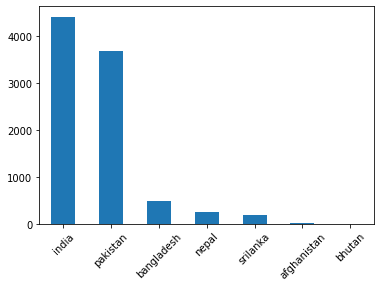

In [17]:
sample_df['location'].value_counts().plot.bar(rot=45)

In [ ]:
# sample_df.to_csv("Data_TagTog_NotAnnotated/sampled_9000_relevant_data.csv", header=True, index = False)

# 5. create_data_for_annotation

In [18]:
sample_df = pd.read_csv('Data_TagTog_NotAnnotated/sampled_9000_relevant_data.csv', header=[0])
sample_df.drop(columns=["Relevance"], inplace=True)

chunk_size = int(sample_df.shape[0] / 18)
i = 10
for start in range(0, sample_df.shape[0], chunk_size):
    df_subset = sample_df.iloc[start:start + chunk_size]
    filename = 'Data_TagTog_NotAnnotated/TagTog_Data/news_satp_%s.tsv'%i
    df_subset.to_csv(filename, index=False, header=True, sep='\t')
    i += 1
    print(filename, df_subset.shape)

Data_TagTog_NotAnnotated/TagTog_Data/news_satp_10.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_11.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_12.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_13.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_14.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_15.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_16.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_17.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_18.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_19.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_20.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_21.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_22.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_23.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_24.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_25.tsv (

# 6. retrieve_data_from_tagtog

In [2]:
from io import StringIO
from pandarallel import pandarallel

tagtogAPIUrl = "https://www.tagtog.net/-api/documents/v1"
USERNAME = 'ssp180002'
PASSWORD = '1234567'

In [3]:
def get_doc_id(url = tagtogAPIUrl, project = None, folder = None):
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project':project, 'owner': USERNAME, 'search':folder, 'page':'1', 'output':'csv'}
    response = requests.get(url, params=params, auth=auth)
    content = response.text.split('\n')
    return [i.split(',')[0] for i in content]

def get_data(ids, url=tagtogAPIUrl, project = None,folder = None):
 
    # Get entities
    
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'entitiestsv','ids': ids}

    entitiestsv = requests.get(url, params=params, auth=auth)
    
    stringIO = StringIO(entitiestsv.text)
    df = pd.read_csv(stringIO , sep="\t", names = ['text','annotated'])

    index, year, month, country = df.text[1], df.text[3], df.text[5], df.text[7]
    news = df.text[9:].str.cat()
    #.encode("ascii", "ignore").decode()

    target = df[df.annotated == 'Target-1']['text'].tolist()
    source = df[df.annotated == 'Source-1']['text'].tolist()
    action = df[df.annotated == 'Action-1']['text'].tolist()
    location = df[df.annotated == 'Location-1']['text'].tolist()
    date = df[df.annotated == 'Date-1']['text'].tolist()
    
       
    # Get is_relevant and action_type
    
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project': project, 'owner': USERNAME, 'search': 'folder:pool', 'page': '1',
              'output': 'ann.json','ids': ids}
    response = requests.get(url, params=params, auth=auth)
    json_data = response.json()

    
    # if no labels or not confirmed, return None
    if 'm_1' not in json_data['metas']:
        print('No labels', index)
        return
    else:
        is_relevant =  json_data['metas']['m_1']['value']

    if json_data['anncomplete'] == False:
        print('Not confirmed', index)
        return
    

    action_type = None
    if json_data['entities']:
        df2 = pd.json_normalize(json_data['entities'])
        if  'fields.f_17.value' in df2.columns:
            df2 = df2[['fields.f_17.value']].rename(columns={"fields.f_17.value": "action_type"})
            df2 = df2.dropna()
            if len(df2)==0:
                action_type = "NotSpecified"
            else: 
                action_type = df2.action_type.tolist()
    

    return [ids, index, is_relevant, target,	source,	action,	action_type, location,	date, country,	year,	news]


# Retrieve annotations and upload them back

## p1

In [48]:
def get_relevant_anotation_p1(ids, url, project, folder):

    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)

    # get index
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'entitiestsv','ids': ids}

    entitiestsv = requests.get(url, params=params, auth=auth)
    
    stringIO = StringIO(entitiestsv.text)
    df = pd.read_csv(stringIO , sep="\t", names = ['text','annotated'])
    
    if len(df) < 7:
        idx= df.text[1]
        print('too short',idx)

    idx, year, month, country = df.text[1], df.text[3], df.text[5], df.text[7]
    news = df.text[9:].str.cat()
    
    
    # 2.  get annotation json
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'ann.json','ids': ids}
    response = requests.get(url, params=params, auth=auth)

    json_data = response.json()
#     ann_json = str(ann_json)
    
     # if no labels or not confirmed, return None
    if 'm_19' not in json_data['metas']:
        print('No labels', idx)
        is_relevant = ''
# 
    else:
        is_relevant =  json_data['metas']['m_19']['value']
    
    if json_data['anncomplete'] == False:
        print('Not confirmed', idx)
        confirmed = False
    else:
        confirmed = True

    json_data = json.dumps(json_data)
    idx = int(idx)  
    
    return [ids, idx, news, year, month, country, json_data, is_relevant, confirmed]

doc_id = get_doc_id(tagtogAPIUrl, 'satp_news_data_500_p1', 'folder:pool')
# ignore the first row (header) and the final row (null)
doc_id = doc_id[1:-1] 


pandarallel.initialize()

s = pd.Series(doc_id).parallel_apply(get_relevant_anotation, args = (tagtogAPIUrl, project_list[1], folder_list[1])).dropna()
df1 = pd.DataFrame(item for item in s)
df1.columns = ['id','idx','news', 'year', 'month', 'country','annotation','is_relevant','confirmed']
df1['folder'] = i

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


KeyError: 1

In [49]:
project = 'satp_news_data_500_p1'
folder = 'folder:pool'

df1=pd.DataFrame(columns= ['id','idx','news', 'year', 'month', 'country','annotation','is_relevant','confirmed'])

for ids in doc_id:
    
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)

    # get index
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'entitiestsv','ids': ids}

    entitiestsv = requests.get(url, params=params, auth=auth)
    
    stringIO = StringIO(entitiestsv.text)
    df = pd.read_csv(stringIO , sep="\t", names = ['text','annotated'])

    idx, year, month, country = df.text[1], df.text[3], df.text[5], df.text[7]
    news = df.text[9:].str.cat()
    
    
    # 2.  get annotation json
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'ann.json','ids': ids}
    response = requests.get(url, params=params, auth=auth)

    json_data = response.json()
#     ann_json = str(ann_json)
    
     # if no labels or not confirmed, return None
    if 'm_19' not in json_data['metas']:
        print('No labels', idx)
        is_relevant = ''
    else:
        is_relevant =  json_data['metas']['m_19']['value']
    
    if json_data['anncomplete'] == False:
        print('Not confirmed', idx)
        confirmed = False
    else:
        confirmed = True

    json_data = json.dumps(json_data)
    idx = int(idx)  
    
    df1.loc[len(df1)] = [ids, idx, news, year, month, country, json_data, is_relevant, confirmed]

In [52]:
df1['folder'] = 1
df1

,id,idx,news,year,month,country,annotation,is_relevant,confirmed,folder
0,aDsSNhWi1v9QIuD9mGMDoUeLLZL8-news_satp_1.tsv_490,32355,Two Lashkar e Jhangvi LeJ militants Asim alias Kapri and Ishaq alias Bobby confessed to killing four Rangers in Ittehad Town of Karachi the provincial capital of Sindh reports The News on December...,2016,12,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": tru...",True,True,1
1,afF9BkRefsUQ4FkxTeycyZzww1pi-news_satp_1.tsv_500,32398,The Commander Southern Command Lieutenant General Amir Riaz on December 20 said that 700 personnel of the Security Forces SFs have been killed while fighting for the âstability of the countryâ...,2016,12,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": tru...",True,True,1
2,akOmfW0q.i0UrNnecWfzyxKXqVpy-news_satp_1.tsv_489,29171,Meanwhile the underground organization Manipur Naga Peopleâs Front MNPF on August 30 claimed responsibility for explosion that occurred at the private residence of Naga Peopleâs Front NPF MLA ...,2016,8,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": tru...",True,True,1
3,a.V3bcu0ErEcwWwjoG0TDbrJ4ypC-news_satp_1.tsv_480,25445,Islamic State IS in the latest issue of its online magazine Dabiq claimed that the five of the nine Gulshan cafÃ© attackers were suicide fighters reports The Daily Star on August 2 To describe the...,2016,8,bangladesh,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": tru...",True,True,1
4,ayD38njuxXYORkJwE.vmqFmFCMOa-news_satp_1.tsv_492,31739,A senior Muttahida Qaumi Movement MQM worker identified as Sohail Rasheed 30 was shot dead near his home in Naeemabad in Korangi Town of Karachi the provincial capital of Sindh on June 19 reports ...,2016,6,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": tru...",True,True,1
...,...,...,...,...,...,...,...,...,...,...
495,ah2UR._f60G2tGD78Jl50D3p34IO-news_satp_1.tsv_13,31796,Unidentified assailants shot dead a member of Afghan Taliban on Nasir Bagh Road in Peshawar on June 30 reports Daily Times Sources said that the deceased Qari Said Murad was a member of Afghan Tal...,2016,6,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": fal...",False,True,1
496,alXpwlTDtpJhBgbwRf5CTz02krEW-news_satp_1.tsv_14,31418,Unidentified militant shot dead an Internally Displaced Person IDP identified as Musa Khan from North Waziristan Agency of Federally Administered Tribal Areas FATA in Tanzeem Bazaar within the lim...,2016,4,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_19"": {""value"": fal...",False,True,1
497,ap_zvwp.SOqyGk1EiDpNsvZuY4AO-news_satp_1.tsv_32,31872,The Rangers arrested five suspects during an overnight search operation in the Dhobi Ghat and Tauhid Chowk areas of Lines area in Karachi on and recovered weapons from them a

In [4]:
# df1.to_csv('annoation_from_p1.csv',index=False, header=True, sep='\t')
df1= pd.read_csv('annoation_from_p1.csv', header=[0], sep='\t')

## p2- p21

In [4]:
def get_relevant_anotation(ids, url, project, folder):

    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)

    
    
    # get index
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'entitiestsv','ids': ids}

    entitiestsv = requests.get(url, params=params, auth=auth)
    
    stringIO = StringIO(entitiestsv.text)
    df = pd.read_csv(stringIO , sep="\t", names = ['text','annotated'])

    idx, year, month, country = df.text[1], df.text[3], df.text[5], df.text[7]
    news = df.text[9:].str.cat()
    
    
    # 2.  get annotation json
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'ann.json','ids': ids}
    response = requests.get(url, params=params, auth=auth)

    json_data = response.json()
#     ann_json = str(ann_json)
    
     # if no labels or not confirmed, return None
    if 'm_1' not in json_data['metas']:
        print('No labels', idx)
        is_relevant = ''
# 
    else:
        is_relevant =  json_data['metas']['m_1']['value']
    
    if json_data['anncomplete'] == False:
        print('Not confirmed', idx)
        confirmed = False
    else:
        confirmed = True

    
    json_data = json.dumps(json_data)
    idx = int(idx)  
    return [ids, idx, news, year, month, country, json_data, is_relevant, confirmed]


pandarallel.initialize()

df_all = []
# for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,]:
for i in range(2,22):
    p = 'p%s'%i
    print('\n----- %s -----\n'%p)
    project_list = ['demo', 'satp_news_data_500_'+ p]
    folder_list = ['folder:pool/Practice', 'folder:pool']
    
    # Get item ids from the TagTog API
    doc_id = get_doc_id(tagtogAPIUrl, project_list[1], folder_list[1])
    # ignore the first row (header) and the final row (null)
    doc_id = doc_id[1:-1] 
    
    
    s = pd.Series(doc_id).parallel_apply(get_relevant_anotation, args = (tagtogAPIUrl, project_list[1], folder_list[1])).dropna()
    df = pd.DataFrame(item for item in s)
    df.columns = ['id','idx','news', 'year', 'month', 'country','annotation','is_relevant','confirmed']
    df['folder'] = i
    df_all.append(df)
    
df_all = pd.concat(df_all)
df_all 

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

----- p2 -----

No labels 17790

----- p3 -----


----- p4 -----


----- p5 -----


----- p6 -----


----- p7 -----


----- p8 -----


----- p9 -----


----- p10 -----

Not confirmed 33722

----- p11 -----


----- p12 -----

Not confirmed 62219

----- p13 -----

No labels 24196
Not confirmed 4917
Not confirmed 53906
Not confirmed 8666
No labels 28397

----- p14 -----


----- p15 -----


----- p16 -----


----- p17 -----


----- p18 -----

No labelsNo labelsNo labels   89563581256618


Not confirmedNo labelsNot confirmedNot confirmed No labels   895656618 3581225112

62738

Not confirmedNot confirmed  
6273825112

No labels 4858
Not confirmed 4858
No labelsNo labels No labels 8867 
5361119870Not confirmed

 Not confirmedNot confirmed8867 53611

 19870
No labels 31696
Not confirmed 31696
No labels 5725
Not confirmedNo labels  572517611

No labels

 32740
No labels 2596No labels
 No labelsNot confirmed32706  
259646281
Not confirmed
No labels Not confirmed32706  
1058546281

No labelsNot confirmed  1058513554

No labelsNot confirmed  3465213554

Not confirmed 34652
No labels 59911
Not confirmed 59911
No labels 49632
Not confirmed 49632
No labels 52512
Not confirmed 52512
No labels 7623
Not confirmed 7623No labels
 14039
Not confirmed 14039
No labels 59166
Not confirmed 59166
No labels No labels62358
 Not confirmed33684 
No labelsNo labels62358  
Not confirmed2850928153No labels 
33684 
Not confirmed
Not confirmed15310  28509
28153
Not confirmed
 15310
No labels 35687
Not confirmed 35687
No labels 1333
Not confirmed No labels1333
 10375
Not confirmedNo labels 10375 6914
No labels
 Not confirmed42243 
6914
Not confirmed 42243
No labels 21003
Not confirmed 21003
No labels 58289
Not confirmed 58289
No labels 8125No labels
 Not confirmed 383578125

Not confirmed 38357No labels
 50873
Not confirmed 50873
No labels 8101
Not confirmed 81

No labels 13550
Not confirmed 13550
No labels 41001
Not confirmed 41001
No labels 35897
Not confirmed 35897
No labels 58904
Not confirmed No labels58904 
37256No labels
 Not confirmed62466
 Not confirmed37256 
62466
No labels 4392No labels
 Not confirmed59678No labels 
4392Not confirmed
  59678No labels
 1514346415

Not confirmedNot confirmed  1514346415

No labels 63585
Not confirmed No labels63585 
16464
Not confirmed 16464
No labels 60113
Not confirmed 60113
No labels 36879
Not confirmed 36879
No labels 15482
No labelsNot confirmed  5490
15482
Not confirmed 5490
No labels 13537
Not confirmed 13537
No labels 43882
Not confirmed 43882
No labels 47384No labels
 Not confirmed19919 
47384Not confirmed
 19919
No labels 60343
Not confirmed 60343
No labels 24046
Not confirmed 24046
No labels 63972
Not confirmed 63972
No labels 40625
Not confirmed 40625
No labelsNo labels  705254523

Not confirmedNot confirmed 54523 
7052
No labels 20792
Not confirmed 20792
No labels 1114
Not confirmed 1114


In [129]:
# df_all.to_csv('df_all_1.14.csv',index=False, header=True, sep='\t')
# df_all= pd.read_csv('df_all_1.14.csv', header=[0], sep='\t')

In [5]:
# df_all = pd.concat([df_all,df1])
# df_all.to_csv('df_all_1.14_p1_to_p22.csv',index=False, header=True, sep='\t')

df_all= pd.read_csv('df_all_1.14_p1_to_p22.csv', header=[0], sep='\t')

In [6]:
df_all.shape

(10998, 10)

In [7]:
mask =  (df_all.is_relevant != False) | (df_all.confirmed == False)

df_all = df_all[mask].copy()
print(df_all.shape)

df_all.news = df_all.news.astype(str)
df_all.year = df_all.year.astype(int)
df_all.month = df_all.month.astype(int)

(3128, 10)


In [8]:
df_sha1 = pd.read_csv('/home/yibo/SATP/RawSATPData/master_2011To2015.csv', header=[0])
df_sha1['idx'] = df_sha1.index
df_sha2 = pd.read_csv('/home/yibo/SATP/RawSATPData/master_2016To2019.csv', header=[0])
df_sha2 = df_sha2.rename(columns={"index": "idx"})
df_sha = pd.concat([df_sha1, df_sha2])

In [9]:
df_sha.shape, df_all.shape

((98502, 5), (3128, 10))

In [10]:
df_merge = pd.merge(df_all, df_sha, on=['idx', 'year', 'month'],how='inner')
df_merge

,id,idx,news_x,year,month,country,annotation,is_relevant,confirmed,folder,location,news_y
0,aTtuTj.rtBJkEv3Kf4sLUyNx2feC-news_satp_2.tsv_483,23592,A soldier was killed and another sustained injuries when militants opened fire on a forces check post in the Rajgal area along the Pak Afghan border of Bara tehsil revenue unit of Khyber Agency in...,2017,10,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2,pakistan,"A soldier was killed and another sustained injuries when militants opened fire on a forces check post in the Rajgal area, along the Pak-Afghan border, of Bara tehsil (revenue unit) of Khyber Agenc..."
1,aViKiAmUlSMV.RPxbTuuxHXcAGHq-news_satp_2.tsv_481,23107,Meanwhile a tribesman identified as Bahadur Khan was killed in a roadside bomb blast in Dawizai area of Pandyali tehsil revenue unit in Mohmand Agency of on February 22 reports Daily Times,2017,2,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2,pakistan,"Meanwhile, a tribesman, identified as Bahadur Khan, was killed in a roadside bomb blast in Dawizai area of Pandyali tehsil (revenue unit) in Mohmand Agency of on February 22, reports Daily Times."
2,atUOYkjwqsS_LoEbzXDfVnAcBlJK-news_satp_2.tsv_432,20191,Four militants were killed in retaliatory fire by Security Forces SFs as they attempted to attack a Central Reserve Police Force CRPF camp at Sumbal in Bandipora District of Jammu and Kashmir J K ...,2017,6,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2,india,Four militants were killed in retaliatory fire by Security Forces (SFs) as they attempted to attack a Central Reserve Police Force (CRPF) camp at Sumbal in Bandipora District of Jammu and Kashmir ...
3,anPZaBT7lCog0Ef6UDpMylo_28Aq-news_satp_2.tsv_436,17878,A local leader of Jatiyo Samajtantrik Dal JSD a political party was shot to death by unidentified assailants in Baghanbari Swarighat area in Old Dhaka on July 28 reports The Daily Star The decease...,2017,7,bangladesh,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2,bangladesh,"A local leader of Jatiyo Samajtantrik Dal (JSD), a political party, was shot to death by unidentified assailants in Baghanbari Swarighat area in Old Dhaka on July 28, reports The Daily Star. The d..."
4,aPqd8EkrF.HCfqT_xeu9QaQAoDRm-news_satp_2.tsv_450,21194,Four Security Force SF personnel were injured in a grenade attack by militants in Budgam District on August 14 reports Daily Excelsior Militants hurled a grenade at a Road Opening Party ROP of Cen...,2017,8,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2,india,"Four Security Force (SF) personnel were injured in a grenade attack by militants in Budgam District on August 14, reports Daily Excelsior. Militants hurled a grenade at a Road Opening Party (ROP) ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3123,aAdDyZkDAEt32nhLTGP9iCTikPFC-news_satp_1.tsv_35,30422,Two CRPF personnel were injured when Maoists triggered a landmine blast at Narsapuram in Sukma District on November 21 reports The News Nation The blast was carrie

In [11]:
df_merge[df_merge.country != df_merge.location]

,id,idx,news_x,year,month,country,annotation,is_relevant,confirmed,folder,location,news_y


In [12]:
df_merge = df_merge.iloc[:,0:10]
df_merge = df_merge.rename(columns={"news_x": "news"})
df_merge.head()

,id,idx,news,year,month,country,annotation,is_relevant,confirmed,folder
0,aTtuTj.rtBJkEv3Kf4sLUyNx2feC-news_satp_2.tsv_483,23592,A soldier was killed and another sustained injuries when militants opened fire on a forces check post in the Rajgal area along the Pak Afghan border of Bara tehsil revenue unit of Khyber Agency in...,2017,10,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2
1,aViKiAmUlSMV.RPxbTuuxHXcAGHq-news_satp_2.tsv_481,23107,Meanwhile a tribesman identified as Bahadur Khan was killed in a roadside bomb blast in Dawizai area of Pandyali tehsil revenue unit in Mohmand Agency of on February 22 reports Daily Times,2017,2,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2
2,atUOYkjwqsS_LoEbzXDfVnAcBlJK-news_satp_2.tsv_432,20191,Four militants were killed in retaliatory fire by Security Forces SFs as they attempted to attack a Central Reserve Police Force CRPF camp at Sumbal in Bandipora District of Jammu and Kashmir J K ...,2017,6,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2
3,anPZaBT7lCog0Ef6UDpMylo_28Aq-news_satp_2.tsv_436,17878,A local leader of Jatiyo Samajtantrik Dal JSD a political party was shot to death by unidentified assailants in Baghanbari Swarighat area in Old Dhaka on July 28 reports The Daily Star The decease...,2017,7,bangladesh,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2
4,aPqd8EkrF.HCfqT_xeu9QaQAoDRm-news_satp_2.tsv_450,21194,Four Security Force SF personnel were injured in a grenade attack by militants in Budgam District on August 14 reports Daily Excelsior Militants hurled a grenade at a Road Opening Party ROP of Cen...,2017,8,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": true, ""sources"": [], ""metas"": {""m_1"": {""value"": true...",True,True,2


In [34]:
# df_merge.to_csv('df_merge_1.14.csv',index=False, header=True, sep='\t')
# df_merge.drop_duplicates().to_csv('df_merge_1.14.csv',index=False, header=True, sep='\t')

df_merge = pd.read_csv('df_merge_1.14.csv', header=[0], sep='\t')
df_merge.shape

(3038, 10)

In [44]:
df_merge672

,id,idx,news,year,month,country,annotation,is_relevant,confirmed,folder
672,aloWyYnY4wmUtdkkqRbDlmRSd9RC-news_satp_10.tsv_154,33722,The year 2013 is emerging as the deadliest one in decades for the Law Enforcement Agencies (LEAs) in Karachi as in the first six months of 2013 more than 100 Policemen and Rangers personnel have b...,2013,7,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {""m_1"": {""value"": fal...",False,False,10
951,a9DXm3.RgjKMxwnY4F9toKlLOlyy-news_satp_12.tsv_406,62219,"An injured of Chakra Goth ethnic violence, Rizwan son of Ibrahim, succumbed to his injures in a hospital. The deceased was wounded in the night of August 19.",2011,8,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {""m_1"": {""value"": fal...",False,False,12
1148,aP3Eza.krLbCtMkpCbz.xF_R6YYW-news_satp_13.tsv_357,8666,"Police killed five Tehreek e Taliban Pakistan (TTP) militants in a shootout during checking in Zia Colony of Orangi Town in provincial capital Karachi on July 29, reported The News. According to d...",2015,7,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {""m_1"": {""value"": fal...",False,False,13
1149,ai5w3hGmKTeOq0l3NlQ9eHc93nly-news_satp_13.tsv_364,4917,"In worst ever shelling by Pakistan Army for the past several years, six civilians including a Sarpanch (head of Panchayat, village level local self Government institution) were killed and over 20 ...",2015,8,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {""m_1"": {""value"": fal...",False,False,13
1154,aScKEPQh9f6fYcW.ZEM98vkkAf0e-news_satp_13.tsv_150,53906,Hindustan Times reports that two cadres of the Communist Party of India Maoist (CPI Maoist) were arrested from a forest located in Muniguda Police Station area in Rayagada District and a huge quan...,2011,2,india,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {""m_1"": {""value"": fal...",False,False,13
...,...,...,...,...,...,...,...,...,...,...
2982,aU4gr2qyxpRRGe3cmAOX7ifxOAQu-news_satp_21.tsv_495,32689,A suspected militant was killed while another militant was arrested after an encounter with the Gulshan e Maymar Police. According to Sohrab Gothâs Sub Divisional Police Officer (SDPO) Khalid Kh...,2013,4,pakistan,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {}, ""entities"": [], ""...",NaN,False,21
2983,aMCnHUAS7cqKiN..DIDlYD.VX3fi-news_satp_21.tsv_496,715,"JeI on November 18 called a countrywide dawn to dusk hartal (shutdown) for November 19 protesting at the Supreme Court verdict, reports The Independent. Makbul Ahmed, acting ameer (chief) of JeI, ...",2015,11,bangladesh,"{""annotatable"": {""parts"": [""s1s1h1"", ""s1s1p1"", ""s1s2h1"", ""s1s2p1"", ""s1s3h1"", ""s1s3p1"", ""s1s4h1"", ""s1s4p1"", ""s1s5h1"", ""s1s5p1""]}, ""anncomplete"": false, ""sources"": [], ""metas"": {}, ""entities"": [], ""...",NaN,False,21
2984,acsr8yghb_kJkrPl0DBLSu5iCLhG-news_satp_21.tsv_497,34337,"Interior Minister Chaudhry Nisar Ali Khan on August 28 underlined the need for carrying out a targeted operation in Karachi under the supervision of Sindh Government, reports 

In [49]:
df_merge.iloc[1].annotation.copy()

AttributeError: 'str' object has no attribute 'copy'

## post  annotations  p2-p21

In [50]:
def post_annotation(row, url, project, set_not_confirmed = True):
    index = row.name
    row.loc['from'] = 'satp_news_data_500_p%s.'%row.folder

    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)

    file_path = 'plain.html/%s_p%s.tsv'%(index, row.folder)
    save_df = row[['idx', 'year', 'month', 'country', 'news','from']].to_frame().T
    save_df.to_csv(file_path, index = False, header=True, sep='\t')
    
    files = [('files', open(file_path))]
    params = {'project': project, 'owner': USERNAME, 'output':'html'}
    response1 = requests.post(tagtogAPIUrl, params=params, auth=auth, files=files)
    
    json_ann = row.annotation
    if set_not_confirmed:
        json_ann = json_ann.replace('\"anncomplete\": true', '\"anncomplete\": false')
    
    files = [("files", ('text.plain.html', response1.text)), ("files", ('text.ann.json',  json_ann))]  #str(ann_json.iloc[i])
    params = {'project':project, 'owner': USERNAME, 'output':'null','format':'anndoc'}
    response2 = requests.post(url, params=params, auth=auth, files=files)

    if len(response1.text)< 20 or response2.text[1:7]!= '\"ok\":1': 
        print('Failed import, idx:',row.idx, 'row', index, 'folder', row.folder)

In [51]:
pandarallel.initialize()
df_merge[df_merge.folder!=1].parallel_apply(post_annotation, 
                                            args = (tagtogAPIUrl, 
                                                    'TASK_Jan14_p2_to_p21_not_confirmed'), axis=1)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Failed import, idx: 17790 row 52 folder 2
Failed import, idx: 35635 row 1692 folder 17


0       None
1       None
2       None
3       None
4       None
        ... 
2982    None
2983    None
2984    None
2985    None
2986    None
Length: 2948, dtype: object

In [63]:
df_merge[~df_merge.folder.isin([1,18,21])].parallel_apply(post_annotation, 
                                            args = (tagtogAPIUrl, 
                                                    'TASK_Jan14_p2_to_p21_not_confirmed_v2'), axis=1)

Failed import, idx: 17790 row 52 folder 2


0       None
1       None
2       None
3       None
4       None
        ... 
2483    None
2484    None
2485    None
2486    None
2487    None
Length: 1994, dtype: object

## Post annotation from folder 1

In [52]:
df_merge[df_merge.folder==1].parallel_apply(post_annotation, args = (tagtogAPIUrl, 'TASK_Jan14_p1_not_confirmed'), axis=1)

189     None
192     None
202     None
208     None
225     None
        ... 
3033    None
3034    None
3035    None
3036    None
3037    None
Length: 90, dtype: object

<AxesSubplot:>

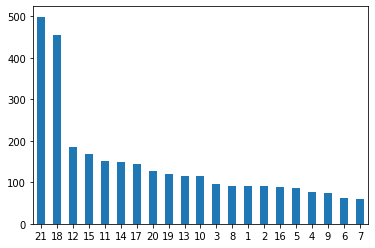

In [60]:
df_merge.folder.value_counts().plot.bar(rot=0)

# Retrieve

In [225]:
pandarallel.initialize()

for i in range(10,11):
    p = 'p%s'%i
    print('\n----- %s -----\n'%p)
    project_list = ['demo', 'satp_news_data_500_'+ p]
    folder_list = ['folder:pool/Practice', 'folder:pool']
    
    # Get item ids from the TagTog API
    doc_id = get_doc_id(tagtogAPIUrl, project_list[1], folder_list[1])
    # ignore the first row (header) and the final row (null)
    doc_id = doc_id[1:-1] 
    

    s = pd.Series(doc_id).parallel_apply(get_data, args = (tagtogAPIUrl, project_list[1], folder_list[1])).dropna()
    df_all = pd.DataFrame(item for item in s)
    df_all.columns = ['id','index','is_relevant', 'target', 'source', 'action', 'action_type' , 'location', 'date','country', 'year', 'news']
    
#     df_all.to_csv('Data_TagTog_Annotated/'+ p +'.csv', header=True, index=False)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

----- p10 -----

Not confirmed 33722


## Concatenation of all the annotations

In [7]:
df_list=[]
for i in range(1,16):
    p = 'p%s'%i
    print('%s'%p, end = ' ')
    df = pd.read_csv('Data_TagTog_Annotated/'+ p +'.csv', header=[0]) 
    df_list.append(df)

p1 p2 p3 p4 p5 p6 p7 p8 p9 p10 p11 p12 p13 p14 p15 

In [8]:
df_total = pd.concat(df_list).reset_index(drop=True)
df_total

,id,is_relevant,target,source,action,action_type,location,date,country,year,news,index
0,32355,True,"['Rangers', 'Rangers', 'Military Police']","['Lashkar e Jhangvi LeJ', 'militants', 'milita...","['killing', 'killed', 'gunned']","['Armed Assault', 'Armed Assault', 'Armed Assa...",['Karachi'],['December 6'],pakistan,2016,Two Lashkar e Jhangvi LeJ militants Asim alias...,NaN
1,32398,True,"['Security Forces', 'SFs', 'civilians']",NaN,"['killed', 'fighting', 'wounded', 'fighting', ...","['Unknown', 'Unknown', 'Unknown', 'Unknown', '...",NaN,['December 20'],pakistan,2016,The Commander Southern Command Lieutenant Gene...,NaN
2,29171,True,"['Naga', 'Naga', 'Nagas', 'Naga']","['Manipur Naga Peopleâ€™s Front', 'MNPF', 'MNP...","['explosion', 'exploded', 'bomb', 'attack']","['Bombing/Explosion', 'Bombing/Explosion', 'Bo...",NaN,['August 30'],india,2016,Meanwhile the underground organization Manipur...,NaN
3,25445,True,"['Artisan Restaurant', 'foreigners', 'hostages']","['attackers', 'suicide fighters', 'suicide sol...","['gun battle', 'killing', 'injuring']","['Armed Assault', 'Armed Assault', 'Armed Assa...",['Dhaka'],"['August', '27th']",bangladesh,2016,Islamic State IS in the latest issue of its on...,NaN
4,31739,True,"['Muttahida Qaumi Movement', 'MQM', 'MQM']",NaN,['shot'],['Assassination'],"['Naeemabad', 'Korangi', 'Karachi', 'Sindh']",['June 19'],pakistan,2016,A senior Muttahida Qaumi Movement MQM worker i...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7484,10483,False,[],[],[],NaN,[],[],nepal,2015,Clashes between demonstrators and Police leave...,a9qjjlMsQqy8XtuhYUJ6QMLlDz88-news_satp_15.tsv_46
7485,42333,False,[],[],[],NaN,[],[],india,2012,The death toll in the ongoing clashes between ...,a6U4BlcbFbLRZKmdIMjCcxSEV7ni-news_satp_15.tsv_35
7486,21314,False,[],[],[],NaN,[],[],pakistan,2014,An unnamed security official revealed that Fro...,aBikefqUY7LvQEJe5Sn96IE92aEK-news_satp_15.tsv_39
7487,58183,True,"['Police', 'Police']",['militants'],"['grenade', 'grenade', 'exploded']","['Bombing/Explosion', 'Bombing/Explosion', 'Bo...",['Srinagar'],['October 16'],india,2011,Police said that militants hurled a grenade on...,a8iR07wYXkm9CV3iPTxqGE4CaaMC-news_satp_15.tsv_52


 ## Running Performances

<ipython-input-9-09c4084b8dd4>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list, width=0.5)


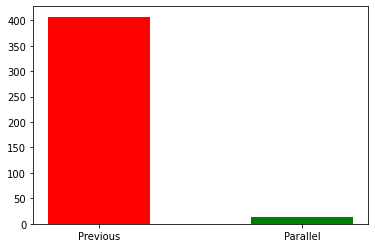

In [9]:
import matplotlib.pyplot as plt

name_list = ['Previous','Parallel']
num_list = [407,13]
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list, width=0.5)
plt.show()